In [ ]:
!pip install rasterio

In [1]:
import rasterio as rio
import skimage
from pprint import pprint
# from skimage import io
import numpy as np
import matplotlib.pyplot as plt
# from skimage import filters
from skimage import exposure
from skimage import measure

In [2]:
skimage.__version__

'0.19.2'

In [2]:
with rio.open('/home/data/flood_tempcnn_1.tiff') as f:
    # pprint(dir(f))
    img = f.read(out_dtype='uint8')
    # print(help(f.read))
# plt.imshow(im)
img = img.squeeze()
height, width = img.shape

(-0.5, 875.5, 1008.5, -0.5)

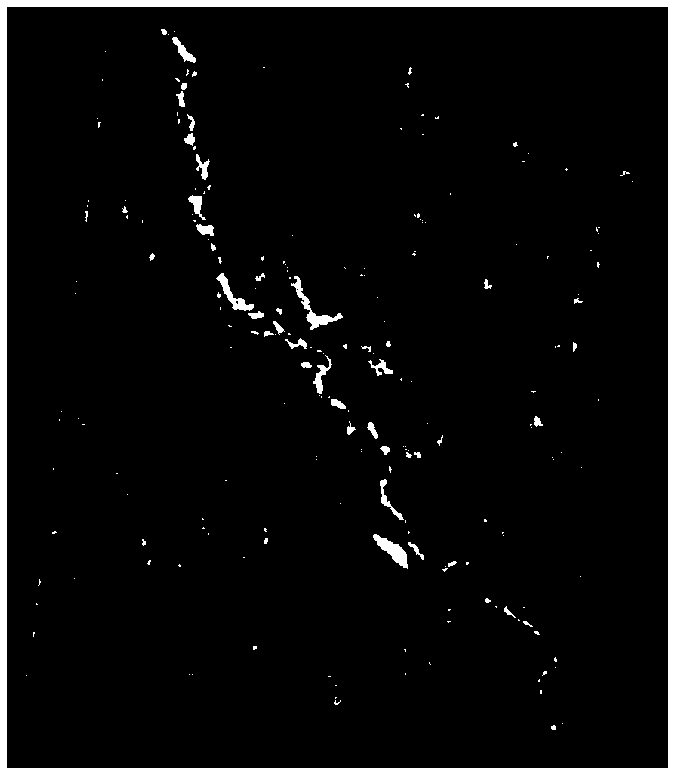

In [3]:
sc_factor = 60
plt.figure(figsize=(height//sc_factor, width//sc_factor))
plt.imshow(img, cmap='gray', interpolation='nearest')
plt.axis('off')

In [4]:
# all_labels = measure.label(img)
# all_labels[all_labels != 84] = 0
# np.unique(all_labels)

In [5]:
blobs_labels = measure.label(img, background=0)
# np.unique(blobs_labels)

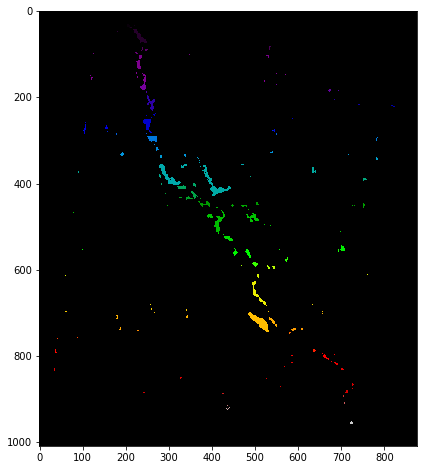

In [6]:
sc_factor = 100
plt.figure(figsize=(height//sc_factor, width//sc_factor))
plt.imshow(blobs_labels, cmap='nipy_spectral', interpolation='nearest')
# plt.axis('off')

In [7]:
properties = measure.regionprops(blobs_labels)
# properties[0]['axis_major_length']

In [8]:
props = {'area': list(),
         'label': list(),
         'orientation': list(),
         'eccentricity': list()}

for segment in properties:
    props['area'].append(segment['area'])
    props['label'].append(segment['label'])
    props['orientation'].append(segment['orientation']*180/np.pi + 90)
    props['eccentricity'].append(segment['eccentricity'])

for key, value in props.items():
    props[key] = np.array(value)

# Orientation wrt North
props['orientation_north'] = list()

for item in props['orientation']:
    if item < 90:
        props['orientation_north'].append(f'N{90 - item:.0f}E')
    elif item > 90:
        props['orientation_north'].append(f'N{item - 90:.0f}W')
    else:
        props['orientation_north'].append(f'N')

props.keys()

dict_keys(['area', 'label', 'orientation', 'eccentricity', 'orientation_north'])

In [9]:
props['area'].sum()

8848

In [10]:
props['area'].argmax()

84

In [11]:
np.flip(np.sort(props['area']))

array([911, 826, 682, 415, 377, 358, 343, 287, 278, 251, 169, 159, 153,
       151, 140, 140, 134, 123, 112, 106, 105,  98,  87,  80,  77,  68,
        63,  56,  54,  54,  53,  47,  47,  46,  46,  45,  45,  42,  42,
        42,  39,  38,  38,  38,  37,  35,  34,  33,  32,  31,  31,  28,
        27,  27,  27,  26,  25,  24,  24,  23,  23,  22,  22,  22,  22,
        21,  21,  21,  20,  18,  17,  17,  17,  16,  15,  15,  15,  15,
        14,  14,  14,  14,  11,  11,  11,  11,  10,  10,  10,   9,   9,
         9,   9,   9,   8,   8,   8,   8,   8,   7,   7,   7,   7,   7,
         7,   6,   6,   6,   6,   6,   6,   5,   5,   5,   5,   5,   5,
         5,   5,   5,   5,   5,   4,   4,   4,   4,   4,   4,   4,   4,
         4,   4,   4,   4,   4,   4,   4,   3,   3,   3,   3,   3,   3,
         3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
         3,   3,   3,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   

In [63]:
area_select = 415
props['label'][props['area'] == area_select]

array([119])

In [64]:
np.where(props['area'] == area_select)[0]

array([118])

In [65]:
index = int(np.where(props['area'] == area_select)[0][0])
print(f'Index is: {index}')

label = props['label'][index]
print(f'Label is: {label}')

print(f'Orientation wrt North: {props["orientation_north"][index]}')

Index is: 118
Label is: 119
Orientation wrt North: N17E


In [66]:
blobs_labels_select = blobs_labels.copy()
blobs_labels_select[blobs_labels_select != label] = 0

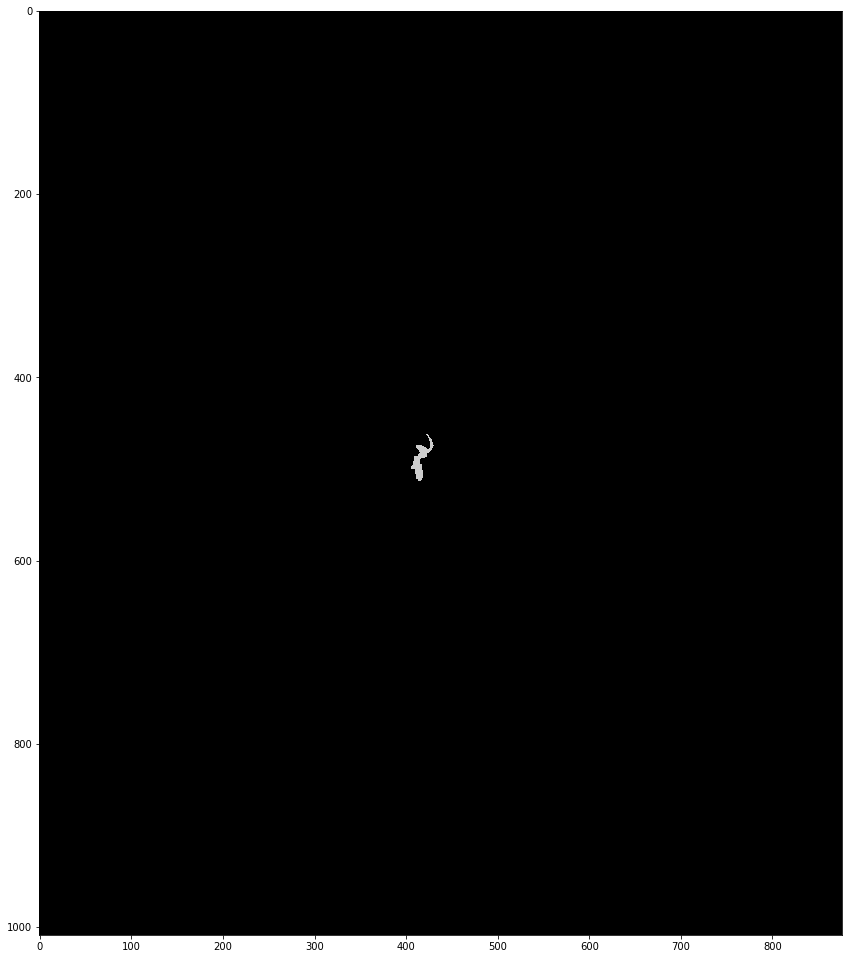

In [67]:
sc_factor = 50
plt.figure(figsize=(height//sc_factor, width//sc_factor))
plt.imshow(blobs_labels_select, cmap='nipy_spectral', interpolation='nearest')
# plt.axis('off')

In [17]:
from scipy import stats
orient_mean = stats.circmean(props['orientation'], low=0, high=180)
orient_std = stats.circstd(props['orientation'], low=0, high=180)

if  orient_mean < 90:
    print(f'Circular mean: N{90 - orient_mean:.0f}E')
elif orient_mean > 90:
    print(f'Circular mean: N{orient_mean - 90:.0f}W')
else:
    print(f'Circular mean: N{orient_mean:.0f}')
    
if  orient_std < 90:
    print(f'Circular Standard Deviation: N{90 - orient_std:.2f}E')
elif orient_std > 90:
    print(f'Circular Standard Deviation: N{orient_std - 90:.2f}W')
else:
    print(f'Circular Standrad Deviation: N{orient_std:.2f}')

Circular mean: N36W
Circular Standard Deviation: N48.22E


In [23]:
y0, x0

(802.3506493506494, 663.9350649350649)

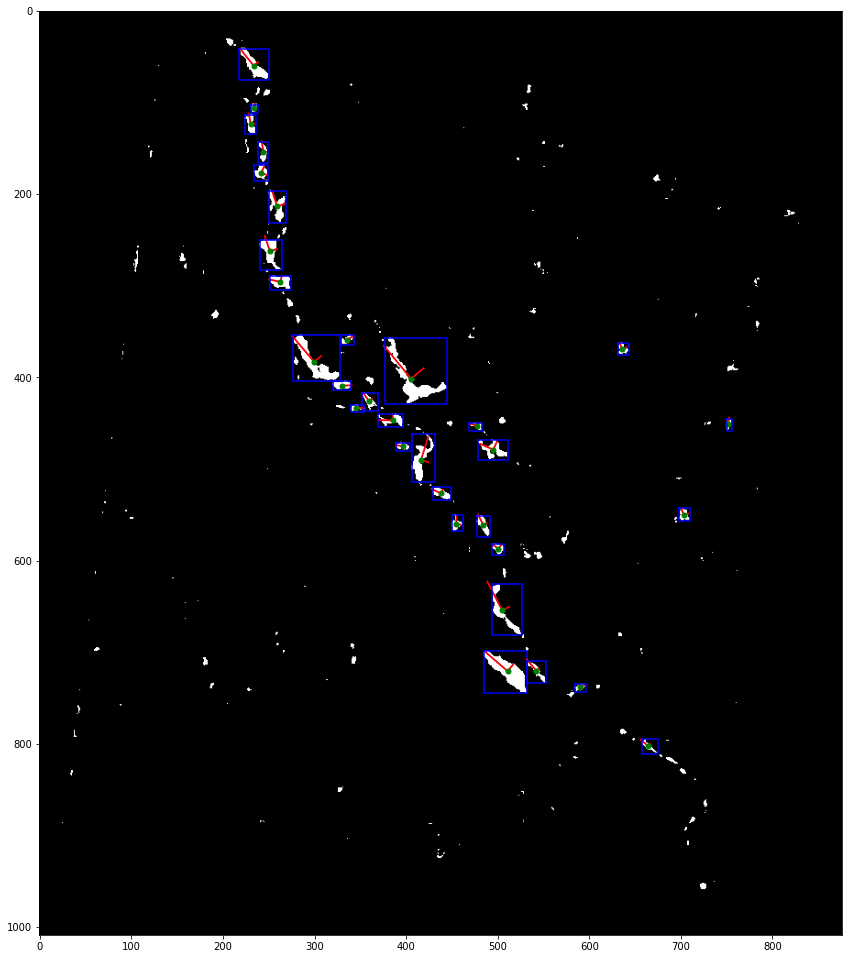

In [25]:
import math
from skimage.draw import ellipse_perimeter

fig, ax = plt.subplots(figsize=(height//50, width//50))


for p in properties:
    if p.area > 50:
        y0, x0 = p.centroid
        orientation = p.orientation
        x1 = x0 + math.cos(orientation) * 0.5 * p.axis_minor_length
        y1 = y0 - math.sin(orientation) * 0.5 * p.axis_minor_length
        x2 = x0 - math.sin(orientation) * 0.5 * p.axis_major_length
        y2 = y0 - math.cos(orientation) * 0.5 * p.axis_major_length
        
        # rr, cc = ellipse_perimeter(int(x0), int(y0), props.axis_major_length, props.axis_minor_length, orientation, img.shape)
        # img[rr, cc] = (1, 0, 1)
        
        ax.plot((x0, x1), (y0, y1), '-r', linewidth=1.8)
        ax.plot((x0, x2), (y0, y2), '-r', linewidth=1.8)
        ax.plot(x0, y0, '.g', markersize=10)

        minr, minc, maxr, maxc = p.bbox
        bx = (minc, maxc, maxc, minc, minc)
        by = (minr, minr, maxr, maxr, minr)
        ax.plot(bx, by, '-b', linewidth=1.5)
ax.imshow(img, cmap=plt.cm.gray)
# ax.axis((0, 600, 600, 0))
# plt.show()

In [87]:
dummy = np.zeros((10, 10), dtype=np.int8)
dummy[4:8, 4] = 1
# dummy [[4, 3, 2], [4, 5, 6]] = 1
properties = measure.regionprops(dummy)
properties[0].orientation*180/np.pi

0.0

In [ ]:
help(measure.regionprops)

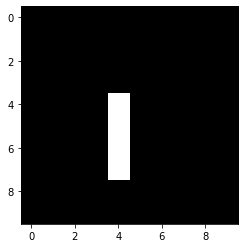

In [88]:
plt.imshow(dummy, cmap='gray')

In [ ]:
help(measure.regionprops)

In [3]:
image = np.asarray(im)
image

array([[[128, 128, 128],
        [128, 128, 128],
        [128, 128, 128],
        ...,
        [  1,   2,  50],
        [  1,   2,  50],
        [  1,   2,  50]],

       [[128, 128, 128],
        [128, 128, 128],
        [128, 128, 128],
        ...,
        [  1,   2,  50],
        [  1,   2,  50],
        [  1,   2,  50]],

       [[128, 128, 128],
        [128, 128, 128],
        [128, 128, 128],
        ...,
        [  1,   2,  50],
        [  1,   2,  50],
        [  1,   2,  50]],

       ...,

       [[128, 128, 128],
        [128, 128, 128],
        [128, 128, 128],
        ...,
        [ 32,  40,  43],
        [ 37,  45,  48],
        [ 38,  46,  49]],

       [[128, 128, 128],
        [128, 128, 128],
        [128, 128, 128],
        ...,
        [ 37,  45,  48],
        [ 43,  51,  54],
        [ 44,  52,  55]],

       [[128, 128, 128],
        [128, 128, 128],
        [128, 128, 128],
        ...,
        [ 41,  49,  52],
        [ 46,  54,  57],
        [ 48,  56,  59]]

In [4]:
red = image[..., 0]
green = image[..., 1]
blue = image[..., 2]

In [5]:
image[..., [0]].dtype

dtype('uint8')

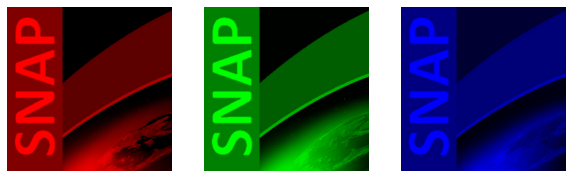

In [6]:
fig, axes = plt.subplots(figsize=(10, 8), ncols=3, nrows=1)
ch_names = ['Reds', 'Blues', 'Greens']
for i in range(3):
    temp = np.zeros(image.shape, dtype='uint8')
    temp[:, :, i] = image[..., i]
    axes[i].imshow(temp)
    axes[i].set_axis_off()

In [7]:
height, width = red.shape
height, width

(900, 900)

In [14]:
centre_idx = np.random.randint(low=0,
                               high=height,
                               size=(10, 2),
                               dtype='uint16')
centre_idx

array([[102, 841],
       [621, 851],
       [868, 273],
       [606,  59],
       [817,  99],
       [601, 772],
       [536, 887],
       [513, 298],
       [785, 704],
       [266, 777]], dtype=uint16)

In [33]:
kheight, kwidth = kernel = (80, 80)
kheight, kwidth

(80, 80)

In [46]:
idx = 7
up = centre_idx[idx, 0]  - kheight
down = centre_idx[idx, 0] + kheight

left = centre_idx[idx, 1] - kwidth
right = centre_idx[idx, 1] + kwidth

In [47]:
# valid_mask = ~np.any((up < 0, down >= height, left < 0, right >= width))
# valid_mask

In [48]:
# centre_idx_valid = centre_idx[valid_mask]
# up = up[valid_mask]
# down = down[valid_mask]

# left = left[valid_mask]
# right = right[valid_mask]

In [49]:
mask = np.zeros((height, width), dtype=np.uint8)
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [50]:
mask[up:down, left:right] = 1
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

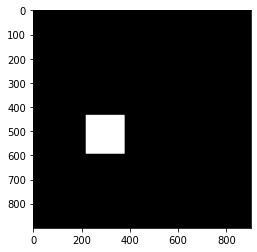

In [51]:
plt.imshow(mask, cmap=plt.cm.get_cmap('Greys').reversed())

In [ ]:
red_list = list()
for i in centre_idx_valid:
    red_list.append(red[up[i]:down[i], left[i]:right[i]])
        
red_list = np.stack(red_list)
red_list.shape

In [90]:
red.shape

(900, 900)

In [ ]:
for i in range(10):
    print(centre_idx_valid[i], up[i], down[i], left[i], right[i])